In [1]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.features import build_features

sns.set_style()
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Estimación de Insumos necesarios en el área ambulatoria

Dentro del área ambulatoria, se quieren estimar la cantidad de:

- Consultas Nuevas
- Consultas Repetidas
- Boxes
- Procedimientos Frecuentes (Tomografías, Resonancias, etc...)

In [3]:
df = pd.read_csv(
    "../data/processed/desglose_sociodemografico_ambulatorio.csv", sep=";", encoding="latin-1"
)

df["ano"] = pd.to_datetime(df["ano"], format="%Y")
df = df.query("ano < '2023-01-01'")

In [4]:
DIAGS_RELEVANTES = [
    "C33X",
    "C340",
    "C341",
    "C342",
    "C343",
    "C381",
    "C384",
    "C450",
    "C780",
    "C782",
    "D143",
    "D381",
    "E848",
    "I080",
    "I081",
    "I340",
    "I351",
    "I352",
    "I420",
    "I456",
    "I472",
    "I495",
    "I710",
    "I712",
    "J47X",
    "J679",
    "J841",
    "J848",
    "J849",
    "J860",
    "J869",
    "J955",
    "M348",
    "T820",
    "T821",
    "Z450",
]

In [5]:
df_relevantes = df[df["codigo_diagnostico"].isin(DIAGS_RELEVANTES)]

## Estimación de Consultas Nuevas y Consultas Repetidas

En primer lugar, se intenará responder a la cantidad de consultas nuevas/repetidas que se realizarán en un futuro en el INT. Se realizará un análisis exploratorio para identificar tendencias o datos relevantes sobre las consultas.

In [6]:
resumen_consultas_globales = (
    df.groupby(["ano", "tipoatencion"])["cantidad_de_consultas"].sum().unstack()
)
resumen_relevantes = (
    df_relevantes.groupby(["ano", "tipoatencion"])["cantidad_de_consultas"].sum().unstack()
)

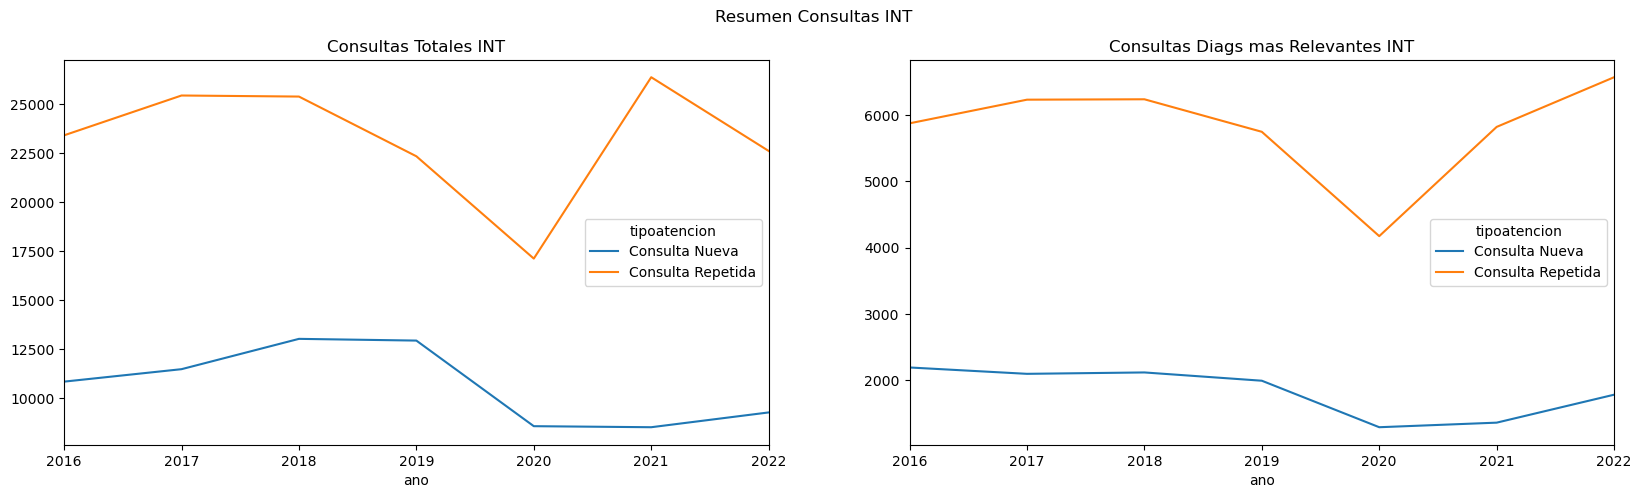

In [7]:
fig, axis = plt.subplots(1, 2, sharey=False, figsize=(20, 5))
resumen_consultas_globales.plot(
    ax=axis[0], title="Consultas Totales INT", y=["Consulta Nueva", "Consulta Repetida"]
)
resumen_relevantes.plot(
    ax=axis[1],
    title="Consultas Diags mas Relevantes INT",
    y=["Consulta Nueva", "Consulta Repetida"],
)
plt.suptitle("Resumen Consultas INT")
plt.show()

Ahora, sabiendo cuantas consultas nuevas y consultas repetidas existen en total, es posible
hacer la estimación de consultas al aumentarlas. Asumiendo un aumento del 79% (aumento predicho
en pacientes hospitalizados), la cantidad de consultas sería:

In [8]:
resumen_relevantes_aumentadas = resumen_relevantes * 1.79

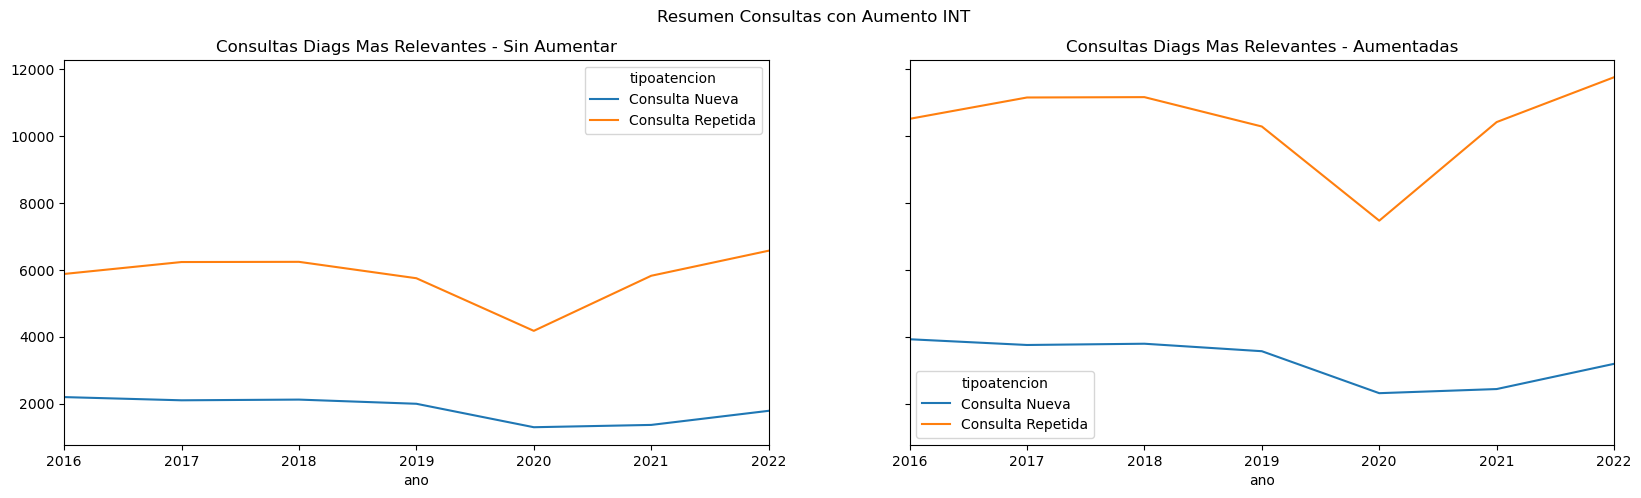

In [9]:
fig, axis = plt.subplots(1, 2, sharey=True, figsize=(20, 5))
resumen_relevantes.plot(
    ax=axis[0],
    title="Consultas Diags Mas Relevantes - Sin Aumentar",
    y=["Consulta Nueva", "Consulta Repetida"],
)
resumen_relevantes_aumentadas.plot(
    ax=axis[1],
    title="Consultas Diags Mas Relevantes - Aumentadas",
    y=["Consulta Nueva", "Consulta Repetida"],
)

plt.suptitle("Resumen Consultas con Aumento INT")
plt.show()

Para estimar la cantidad de Boxes se calcularán la cantidad de consultas que se deben atender en cada día, solamente tomando días laborales.

In [10]:
FECHA_INICIO = resumen_relevantes_aumentadas.index.min()
FECHA_TERMINO = resumen_relevantes_aumentadas.index.max() + pd.Timedelta("365 days")

dias_laborales = build_features.obtener_cantidad_de_dias_laborales_por_anio(
    FECHA_INICIO, FECHA_TERMINO
)

display(dias_laborales)

fecha
2016-01-01    252
2017-01-01    248
2018-01-01    247
2019-01-01    249
2020-01-01    252
2021-01-01    251
2022-01-01    250
dtype: int64

In [16]:
# Divide la cantidad de consultas anuales por los dias laborales
consultas_por_dia = resumen_relevantes.divide(dias_laborales, axis=0)
consultas_por_dia_aumentadas = resumen_relevantes_aumentadas.divide(dias_laborales, axis=0)

display(consultas_por_dia)
display(consultas_por_dia_aumentadas)

tipoatencion,Consulta Nueva,Consulta Repetida,Miscaleneo,Procedimiento
ano,,,,
2016-01-01,8.698413,23.325397,NaN,0.142857
2017-01-01,8.451613,25.141129,NaN,0.141129
2018-01-01,8.570850,25.267206,NaN,0.093117
2019-01-01,8.000000,23.092369,NaN,0.056225
2020-01-01,5.119048,16.567460,NaN,0.023810
2021-01-01,5.414343,23.203187,0.003984,0.051793
2022-01-01,7.124000,26.296000,0.008000,0.056000


tipoatencion,Consulta Nueva,Consulta Repetida,Miscaleneo,Procedimiento
ano,,,,
2016-01-01,15.570159,41.752460,NaN,0.255714
2017-01-01,15.128387,45.002621,NaN,0.252621
2018-01-01,15.341822,45.228300,NaN,0.166680
2019-01-01,14.320000,41.335341,NaN,0.100643
2020-01-01,9.163095,29.655754,NaN,0.042619
2021-01-01,9.691673,41.533705,0.007131,0.092709
2022-01-01,12.751960,47.069840,0.014320,0.100240


Habiendo determinado la cantidad de consultas por día, es posible calcular la cantidad de Boxes
necesarios para suplir tal demanda. Asumiendo que un día laboral tiene 9 horas de trabajo, y que
se atienden 3 consultas por hora, entonces:

$CapacidadDeBox = (HorasHabilesEnDia*ConsultasPorHora)$
$CapacidadDeBox = 9 Horas * 3 ConsultasPorHora = 27$ Consultas Por Hora

In [17]:
HORAS_POR_DIA_LABORAL = 9

CONSULTAS_POR_HORA_CONSULTA_NUEVA = 3
CONSULTAS_POR_HORA_CONSULTA_REPETIDA = 4

CAPACIDAD_DE_BOX_CONSULTA_NUEVA = HORAS_POR_DIA_LABORAL * CONSULTAS_POR_HORA_CONSULTA_NUEVA
CAPACIDAD_DE_BOX_CONSULTA_REPETIDA = HORAS_POR_DIA_LABORAL * CONSULTAS_POR_HORA_CONSULTA_REPETIDA

print(f"Capacidad Consulta Nueva: {CAPACIDAD_DE_BOX_CONSULTA_NUEVA} Consultas por Hora")
print(f"Capacidad Consulta Repetida: {CAPACIDAD_DE_BOX_CONSULTA_REPETIDA} Consultas por Hora")

Capacidad Consulta Nueva: 27 Consultas por Hora
Capacidad Consulta Repetida: 36 Consultas por Hora


Como ya sabemos la capacidad de un Box, entonces podemos determinar la cantidad de Boxes necesarios
para suplir las consultas diarias:

$BoxesNecesarios = \frac{ConsultasEnUnPeriodo}{CapacidadDeBoxEnPeriodo}$

In [23]:
# Calcula cantidad de boxes necesarios por dia para suplir la cantidad de consultas
consultas_por_dia["boxes_por_dia_consulta_nueva"] = (
    consultas_por_dia["Consulta Nueva"] / CAPACIDAD_DE_BOX_CONSULTA_NUEVA
)
consultas_por_dia["boxes_por_dia_consulta_repetida"] = (
    consultas_por_dia["Consulta Repetida"] / CAPACIDAD_DE_BOX_CONSULTA_REPETIDA
)

consultas_por_dia_aumentadas["boxes_por_dia_consulta_nueva"] = (
    consultas_por_dia_aumentadas["Consulta Nueva"] / CAPACIDAD_DE_BOX_CONSULTA_NUEVA
)
consultas_por_dia_aumentadas["boxes_por_dia_consulta_repetida"] = (
    consultas_por_dia_aumentadas["Consulta Repetida"] / CAPACIDAD_DE_BOX_CONSULTA_REPETIDA
)

In [26]:
display(consultas_por_dia_aumentadas)

tipoatencion,Consulta Nueva,Consulta Repetida,Miscaleneo,Procedimiento,boxes_por_dia_consulta_nueva,boxes_por_dia_consulta_repetida
ano,,,,,,
2016-01-01,15.570159,41.752460,NaN,0.255714,0.576673,1.159791
2017-01-01,15.128387,45.002621,NaN,0.252621,0.560311,1.250073
2018-01-01,15.341822,45.228300,NaN,0.166680,0.568216,1.256342
2019-01-01,14.320000,41.335341,NaN,0.100643,0.530370,1.148204
2020-01-01,9.163095,29.655754,NaN,0.042619,0.339374,0.823771
2021-01-01,9.691673,41.533705,0.007131,0.092709,0.358951,1.153714
2022-01-01,12.751960,47.069840,0.014320,0.100240,0.472295,1.307496


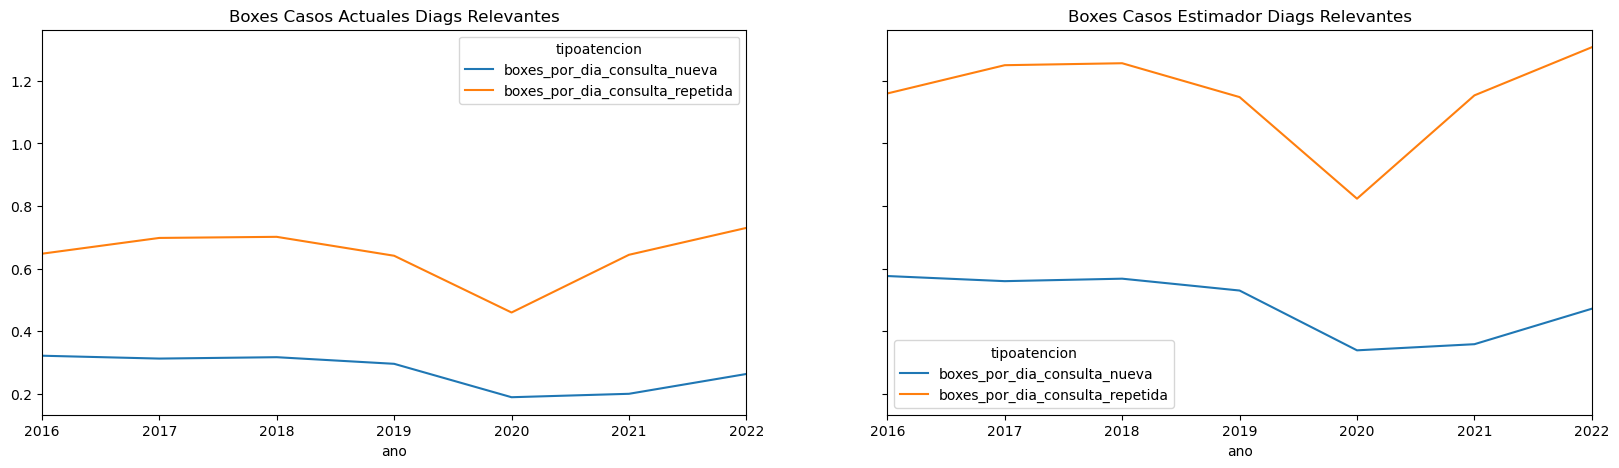

In [25]:
fig, axis = plt.subplots(1, 2, sharey=True, figsize=(20, 5))
consultas_por_dia.plot(
    y=["boxes_por_dia_consulta_nueva", "boxes_por_dia_consulta_repetida"],
    ax=axis[0],
    title="Boxes Casos Actuales Diags Relevantes",
)
consultas_por_dia_aumentadas.plot(
    y=["boxes_por_dia_consulta_nueva", "boxes_por_dia_consulta_repetida"],
    ax=axis[1],
    title="Boxes Casos Estimador Diags Relevantes",
)

plt.show()